In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams

import logging

from sklearn.metrics import mean_absolute_error
logging.getLogger().setLevel(logging.ERROR)


In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    #pd.rolling_mean(timeseries, window=12)
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [3]:
LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)

#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

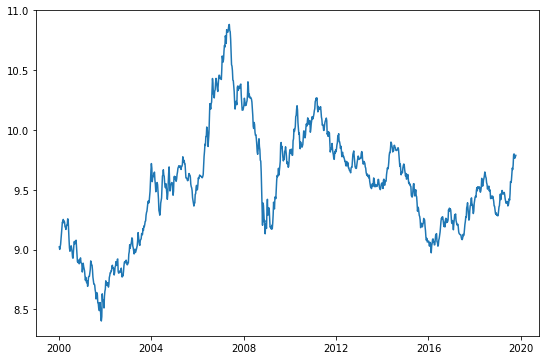

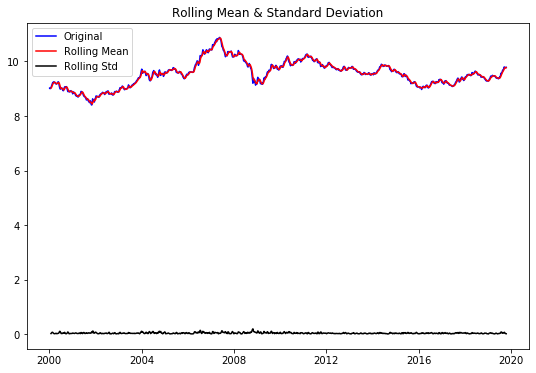

Results of Dickey-Fuller Test:
Test Statistic                   -1.941620
p-value                           0.312742
#Lags Used                        1.000000
Number of Observations Used    1030.000000
Critical Value (1%)              -3.436715
Critical Value (5%)              -2.864350
Critical Value (10%)             -2.568266
dtype: float64


In [4]:

LME = LME.resample('W').mean()
LME_log = np.log(LME)
rcParams['figure.figsize'] = 9, 6

plt.plot(LME_log)
plt.show()
test_stationarity(LME_log)

In [7]:
ar_model = ARMA(LME_log, order = (1,0))
ma_model = ARMA(LME_log, order = (0, 1))

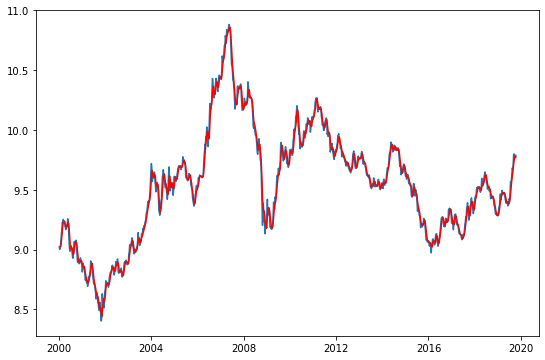

<class 'pandas.core.series.Series'>


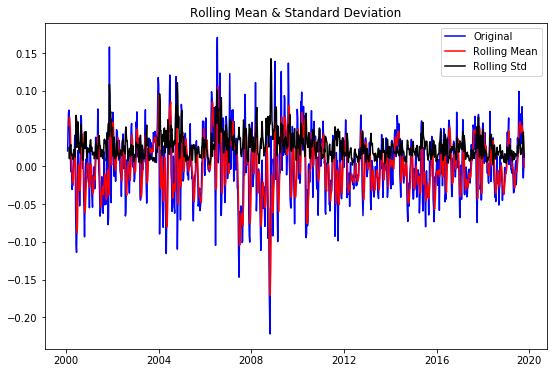

Results of Dickey-Fuller Test:
Test Statistic                -1.027424e+01
p-value                        3.928551e-18
#Lags Used                     5.000000e+00
Number of Observations Used    1.023000e+03
Critical Value (1%)           -3.436758e+00
Critical Value (5%)           -2.864369e+00
Critical Value (10%)          -2.568276e+00
dtype: float64


In [70]:
moving_avg = LME_log.rolling(window=4).mean()
plt.plot(LME_log)
plt.plot(moving_avg, color='red')
#plt.axvline('2018-5-1', color='red', linestyle='--')
plt.show()

moving_diff = LME_log-moving_avg
moving_diff = moving_diff.dropna()
#moving_diff = moving_diff.to_frame()
print(type(moving_diff))
test_stationarity(moving_diff)

In [71]:
LME_log.head()

Unnamed: 1
2000-01-09    9.022673
2000-01-16    9.001529
2000-01-23    9.024324
2000-01-30    9.043483
2000-02-06    9.091805
Freq: W-SUN, Name: Cash Price ($/MT), dtype: float64

## Modeling

IMPORTANT NOTE TO SELF: 
For smoothing using moving average, must RESCALE output predictions using inputs!! 

SECOND NOTE 2 SELF: 
for training/fitting/testing set... 

MODEL FOR DEPLOYMENT: 
Train a model that uses values from a year ago or OLDER to predict values and rescale according to moving averages... 



### TRAINING AND TESTING MODEL PROCEDURES

Use prophet to autobuild models that are trained to test 17 years back to predict for one year ahead
and RECORD RESULTS

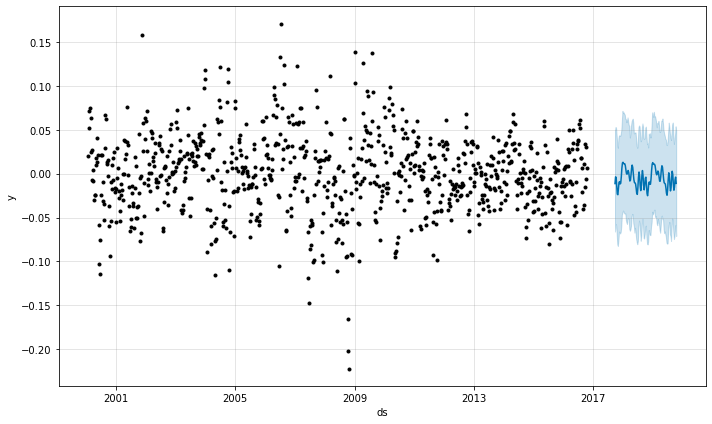

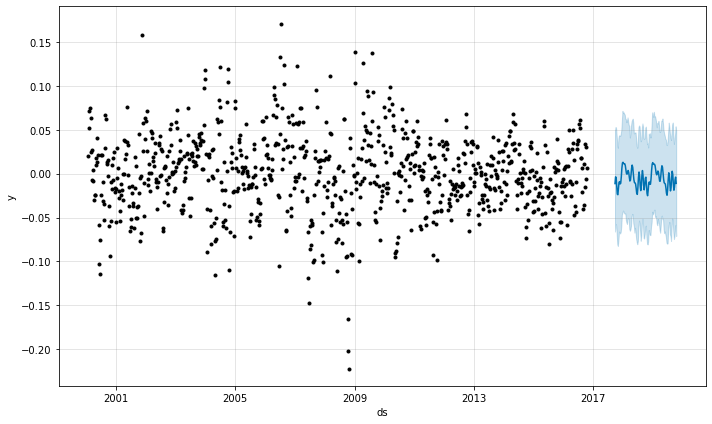

In [75]:
list_one = list(moving_diff.index)
list_two = list(moving_diff)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'y'])
moving_diff

prediction_size = 104
# gap size for 10
gap_size = 52
train_df = df[:-prediction_size-gap_size]

m = Prophet()
m.fit(train_df)

# Predict for FOUR EXTRA DATES for moving average calculations only
test_df = df[-prediction_size-4:]
forecast = m.predict(test_df)
m.plot(forecast)



In [76]:
forecast.index = forecast['ds']
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2017-09-24,2017-09-24,-0.004749,-0.065913,0.049333,-0.004749,-0.004749,-0.006555,-0.006555,-0.006555,-0.006555,-0.006555,-0.006555,0.0,0.0,0.0,-0.011304
2017-10-01,2017-10-01,-0.004759,-0.057440,0.053104,-0.004759,-0.004759,0.001123,0.001123,0.001123,0.001123,0.001123,0.001123,0.0,0.0,0.0,-0.003637
2017-10-08,2017-10-08,-0.004770,-0.058733,0.051493,-0.004770,-0.004770,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.0,0.0,0.0,-0.004393
2017-10-15,2017-10-15,-0.004780,-0.069029,0.042478,-0.004780,-0.004780,-0.009155,-0.009155,-0.009155,-0.009155,-0.009155,-0.009155,0.0,0.0,0.0,-0.013936
2017-10-22,2017-10-22,-0.004791,-0.080638,0.033937,-0.004791,-0.004791,-0.018465,-0.018465,-0.018465,-0.018465,-0.018465,-0.018465,0.0,0.0,0.0,-0.023255


## Modeling the Moving Average!! 

- Will start at the end of the training data and is used ONLY TO FILL IN THE SPACE between the evaluated values and the training data 


In [81]:
# forecast['yhat'].rolling(window=4).mean()
LME_log_train = LME_log[:-prediction_size-gap_size:]

LME_log_train.rolling(window=4).mean().tail()

#moving_avg = LME_log.rolling(window=4).mean()


Unnamed: 1
2016-09-18    9.204419
2016-09-25    9.214131
2016-10-02    9.231544
2016-10-09    9.230837
2016-10-16    9.246855
Freq: W-SUN, Name: Cash Price ($/MT), dtype: float64

In [82]:
LME_log_train.tail(10)

Unnamed: 1
2016-08-14    9.272888
2016-08-21    9.238981
2016-08-28    9.208694
2016-09-04    9.192136
2016-09-11    9.227384
2016-09-18    9.189464
2016-09-25    9.247540
2016-10-02    9.261789
2016-10-09    9.224554
2016-10-16    9.253539
Freq: W-SUN, Name: Cash Price ($/MT), dtype: float64

In [97]:
pd.DataFrame({'mean':tester.rolling(window=3).mean(), 'original': tester})

,mean,original
0,NaN,1.0
1,NaN,2.0
2,2.000000,3.0
3,3.000000,4.0
4,6.000000,11.0
5,7.000000,6.0
6,8.000000,7.0
7,7.000000,8.0
8,8.000000,9.0
9,5.833333,0.5


## Back to Scale before Performance Analysis

In [26]:
test_start_date = forecast.index[0]

yhat = forecast['yhat']

y = moving_diff[test_start_date:]
shifted_by_avg = moving_avg[test_start_date:]

scaled_yhat = forecast['yhat'] + moving_avg[test_start_date:]
scaled_yhat

scaled_y =  moving_diff[test_start_date:] + moving_avg[test_start_date:]
scaled_y

actual_y = LME_log[test_start_date:]

In [45]:
gap_df.index= gap_df['ds']
gap_df
gap_df['yhat']

ds
2016-10-23   -0.023583
2016-10-30   -0.022546
2016-11-06   -0.014850
2016-11-13   -0.008836
2016-11-20   -0.008952
2016-11-27   -0.011446
2016-12-04   -0.009564
2016-12-11   -0.001499
2016-12-18    0.007972
2016-12-25    0.013171
2017-01-01    0.013294
2017-01-08    0.011893
2017-01-15    0.011732
2017-01-22    0.011698
2017-01-29    0.009166
2017-02-05    0.004231
2017-02-12    0.000277
2017-02-19    0.000191
2017-02-26    0.002853
2017-03-05    0.004097
2017-03-12    0.001104
2017-03-19   -0.004532
2017-03-26   -0.008138
2017-04-02   -0.006191
2017-04-09    0.000577
2017-04-16    0.007690
2017-04-23    0.010291
2017-04-30    0.006647
2017-05-07   -0.000724
2017-05-14   -0.007170
2017-05-21   -0.009809
2017-05-28   -0.010019
2017-06-04   -0.011844
2017-06-11   -0.017234
2017-06-18   -0.022795
2017-06-25   -0.022307
2017-07-02   -0.013502
2017-07-09   -0.002092
2017-07-16    0.002418
2017-07-23   -0.003922
2017-07-30   -0.014650
2017-08-06   -0.018643
2017-08-13   -0.011408
2017-08-

In [66]:
'''
y = moving_diff['2018-05-15':]
shifted_by_avg = moving_avg['2018-05-15':]


scaled_yhat = forecast['yhat'] + moving_avg['2018-05-15':]
scaled_yhat

scaled_y =  moving_diff['2018-05-15':] + moving_avg['2018-05-15':]
scaled_y

actual_y = LME_log['2018-05-15':]
'''

In [39]:
frame = { 'scaled_yhat': scaled_yhat, 'scaled_y': scaled_y, 'actual y': actual_y } 
  
results = pd.DataFrame(frame) 
results.head()

,scaled_yhat,scaled_y,actual y
2017-10-22,9.274322,9.366318,9.366318
2017-10-29,9.305294,9.372774,9.372774
2017-11-05,9.354377,9.423757,9.423757
2017-11-12,9.388744,9.432235,9.432235
2017-11-19,9.390333,9.369001,9.369001


In [40]:
results['error'] = results['scaled_y'] - results['scaled_yhat']
results.head()

results['unlogged_scaled_yhat'] = np.exp(results['scaled_yhat'])
results['original_y'] = LME[test_start_date:]


In [41]:
results['error'] = results['original_y'] - results['unlogged_scaled_yhat']

# Mean error results
print(np.abs(results['error']).mean())
print(mean_absolute_error(results['original_y'], results['unlogged_scaled_yhat'] ))

352.65456306732364
352.6545630673237


In [30]:
results.head()

,scaled_yhat,scaled_y,actual y,error,unlogged_scaled_yhat,original_y
2017-10-22,9.274322,9.366318,9.366318,1027.274925,10660.725075,11688.0
2017-10-29,9.305294,9.372774,9.372774,767.623930,10996.076070,11763.7
2017-11-05,9.354377,9.423757,9.423757,829.737303,11549.262697,12379.0
2017-11-12,9.388744,9.432235,9.432235,531.326832,11953.073168,12484.4
2017-11-19,9.390333,9.369001,9.369001,-252.683909,11972.083909,11719.4


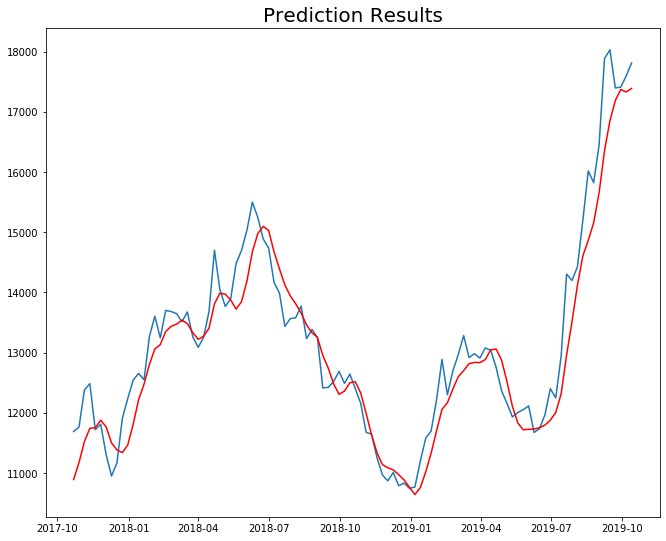

In [102]:
plt.plot(results['original_y'])
plt.plot(results['unlogged_scaled_yhat'], color='red')
plt.title("Prediction Results", fontsize=20)
#plt.axvline('2018-5-1', color='red', linestyle='--')
plt.show()

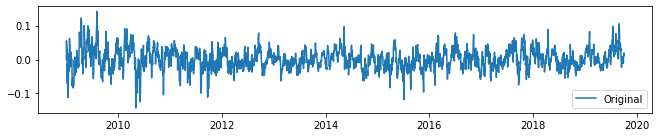

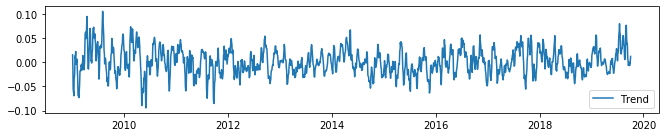

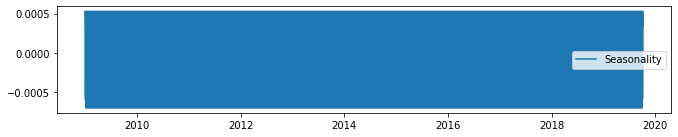

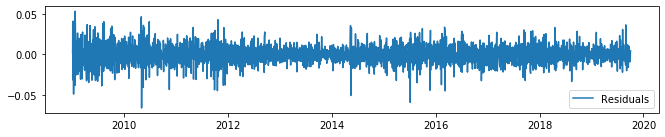

In [186]:
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(exdiff)
#fig = decomposition.plot()
#plt.show()

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(exdiff, label='Original')
plt.legend(loc='best')
plt.show()

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.show()

plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.show()

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

In [187]:
exdiff.to_csv('exdiff_preprocessed.csv', index=True, header=True)

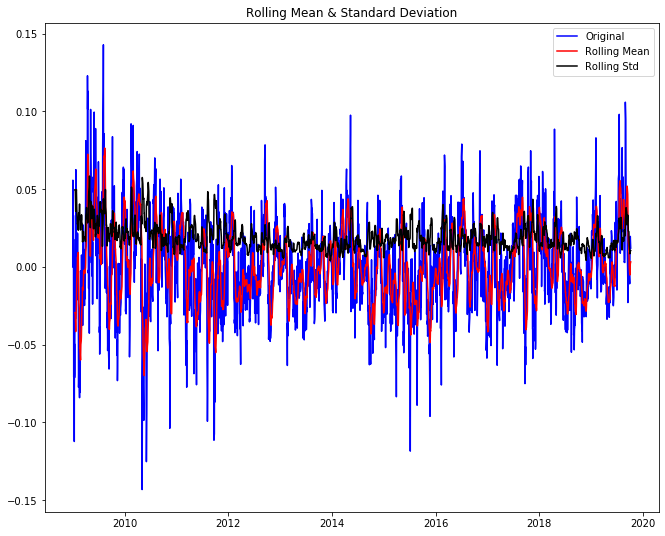

Results of Dickey-Fuller Test:
Test Statistic                -1.621079e+01
p-value                        3.988426e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.807000e+03
Critical Value (1%)           -3.432682e+00
Critical Value (5%)           -2.862570e+00
Critical Value (10%)          -2.567318e+00
dtype: float64


In [66]:
df = pd.read_csv('exdiff_preprocessed.csv')
df.index = df['Unnamed: 1']
df = df.iloc[:, 1:]
df.head()

df = df['Cash Price ($/MT)'].squeeze()
df.index = pd.to_datetime(df.index)
test_stationarity(df)

# Modeling

https://towardsdatascience.com/time-series-forecasting-with-prophet-54f2ac5e722e

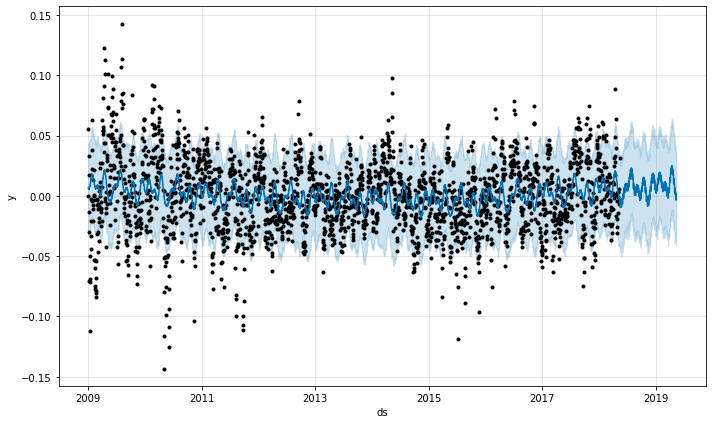

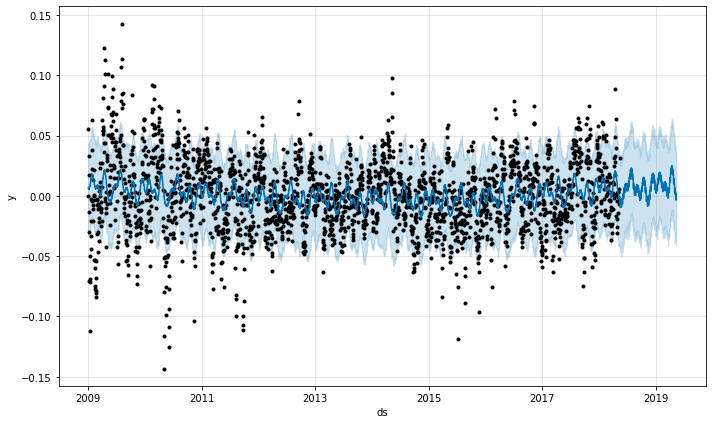

In [88]:
m.plot(forecast)

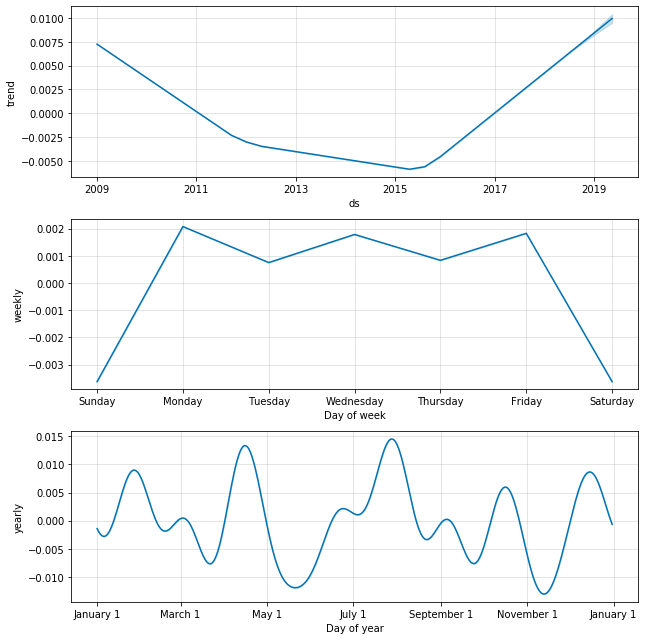

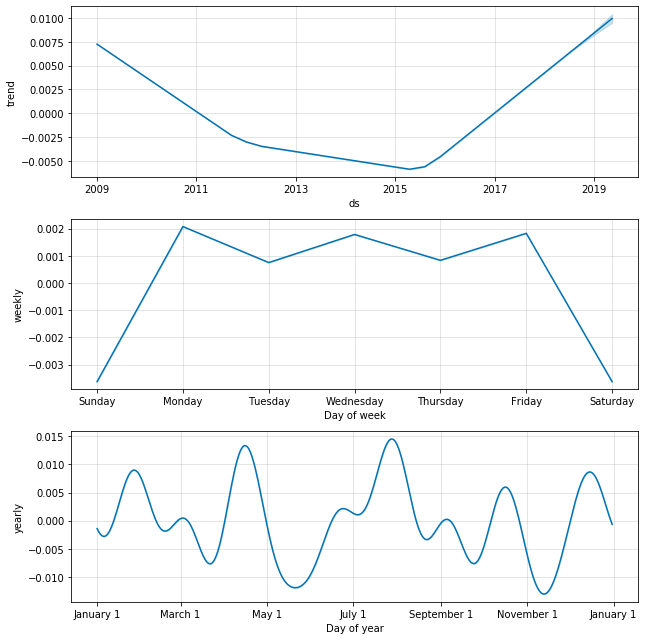

In [89]:
m.plot_components(forecast)

In [42]:
'''Joins predicted values with actual values'''
def make_comparison_dataframe(historical, forecast):
    
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

# Creating comparison dataframe
cmp_df = make_comparison_dataframe(df, forecast)



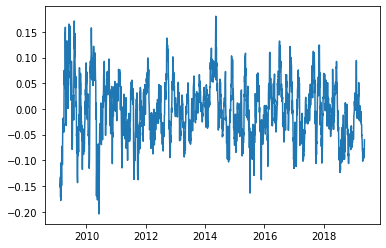

In [49]:
cmp_df['error'] =  cmp_df['y'] - cmp_df['yhat']
cmp_df.head()
plt.plot(cmp_df['error'])

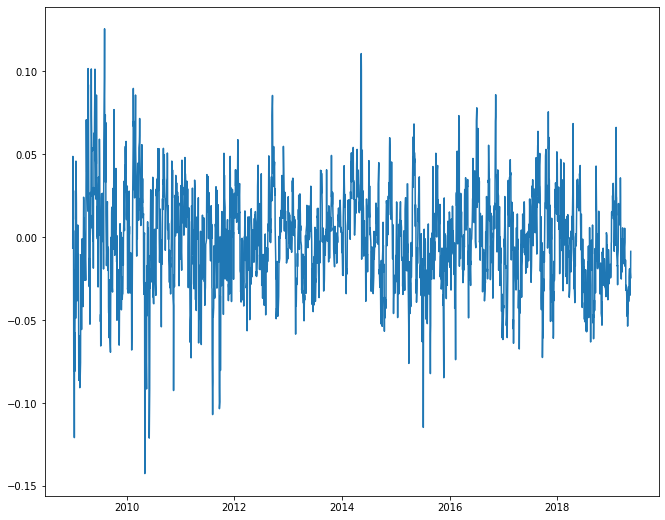

In [151]:
plt.plot(cmp_df['error'])

In [51]:
cmp_df = cmp_df.dropna()

def calculate_forecast_errors(df, prediction_size):
    df = df.copy()
    df['error'] = df['y'] - df['yhat']
    df['percentage'] = 100*df['error']/df['y']
    
    
    predicted_part = df[-prediction_size:]
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    print(predicted_part.head())
    return {'MAPE': error_mean('percentage'), 'MAE': error_mean('error')}

for err_name, err_value in calculate_forecast_errors(cmp_df.dropna(), prediction_size).items():
    print(err_name, err_value)

                yhat  yhat_lower  yhat_upper         y     error  percentage
ds                                                                          
2017-12-20  0.030911   -0.038317    0.101200  0.042610  0.011699   27.455771
2017-12-21  0.030106   -0.045255    0.099914  0.046177  0.016070   34.801897
2017-12-22  0.030545   -0.037697    0.100828  0.051237  0.020692   40.384256
2017-12-25  0.029742   -0.038494    0.100844  0.052215  0.022473   43.039938
2017-12-26  0.027537   -0.041608    0.098748  0.051225  0.023688   46.242715
MAPE 570.8182329084178
MAE 0.04271461087194927


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [46]:
np.sqrt(9)

3.0

In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725
